# Assignment 5 - Question 1: NN Basics

In [1]:
import importlib

modules = [
    "numpy",
    "tensorflow",
    "matplotlib",
    "sklearn"
]

for module in modules:
    try:
        importlib.import_module(module)
        print(f"{module} installed")
    except ImportError:
        print(f"{module} not installed")


numpy installed
tensorflow installed
matplotlib installed
sklearn installed


## I. Fitting Data (8 points)


### Step 0: Review of libraries and installation

In [2]:
# Data handling
import numpy as np
import pandas as pd

# Machine Learning models
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Statistics / Econometrics
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt



### Step 1:  Simulation (0.5 pts)

In [3]:
rng = np.random.default_rng(123)
tf.random.set_seed(123)
n = 400
x = rng.uniform(0, 2*np.pi, size=n)
eps = rng.normal(0, 0.2, size=n)
y = np.sin(x) + eps
x_grid = np.linspace(0, 2*np.pi, 600)


### Step 2: Neural Network Training (2 pts)

In [4]:
x_tf = x.reshape(-1,1).astype("float32")
y_tf = y.astype("float32")
xg_tf = x_grid.reshape(-1,1).astype("float32")

def build_model(activations, units=50, lr=1e-3):
    if isinstance(activations, str):
        activations = [activations]*3  # 3 hidden layers
    model = keras.Sequential([layers.Input(shape=(1,))])
    for act in activations:
        model.add(layers.Dense(units, activation=act))
    model.add(layers.Dense(1))  # linear
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

def train_and_eval(acts, epochs=2000):
    m = build_model(acts)
    es = keras.callbacks.EarlyStopping(monitor="loss", patience=50, restore_best_weights=True)
    m.fit(x_tf, y_tf, epochs=epochs, batch_size=64, verbose=0, callbacks=[es])
    y_hat_train = m.predict(x_tf, verbose=0).ravel()
    y_hat_grid  = m.predict(xg_tf, verbose=0).ravel()
    mse = mean_squared_error(y_tf, y_hat_train)
    return y_hat_grid, mse

configs = {
    "logistic": "sigmoid",
    "tanh": "tanh",
    "relu": "relu",
    "mixed": ["tanh","relu","sigmoid"],
}

results = {name: train_and_eval(acts) for name, acts in configs.items()}

### Step 3: Graphs (2 pts)

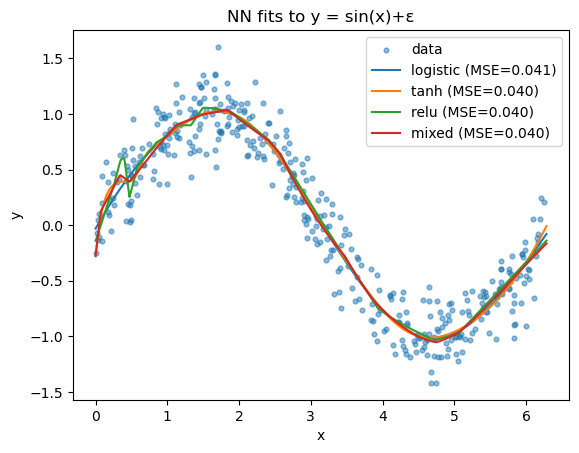

In [5]:
plt.scatter(x, y, s=12, alpha=0.5, label="data")
for name, (yhat, mse) in results.items():
    plt.plot(x_grid, yhat, label=f"{name} (MSE={mse:.3f})")
plt.legend(); plt.xlabel("x"); plt.ylabel("y"); plt.title("NN fits to y = sin(x)+ε")
plt.savefig(r"C:\Users\User\Desktop\DML_NN\Python\Output\NN_Fits_to_y.png", dpi=300, bbox_inches='tight')
plt.show()

### Step 4: Question (0.5 pts)

### 4. Model Comparison – Neural Networks

To determine which neural network fits the data best, we compare the Mean Squared Error (MSE).  
The model with the lowest MSE provides the most accurate approximation of:

$$
y = \sin(x) + \varepsilon
$$

---

#### ✅ Code – Identify Best Model

In [6]:
best_model = min(results, key=lambda k: results[k][1])
print(f"Best performing model: {best_model}  |  MSE = {results[best_model][1]:.4f}")


Best performing model: relu  |  MSE = 0.0402


## II. Learning-rate


### 📌What is the Learning Rate?

The **learning rate (LR)** controls how big the update step is when the optimizer adjusts the weights of the neural network during training.

- If the **learning rate is too high**, the model takes very large steps, which can make the loss function **oscillate or even diverge**, preventing proper learning.
- If the **learning rate is too low**, the model updates the weights very slowly, so training becomes **inefficient** and the network may **get stuck in a poor local minimum**.

Choosing the right learning rate is essential for stable and efficient convergence.


### Step 1: Neural Network training for each learning rate (1.5 pts)

In [7]:
try:
    best_activation = min(results, key=lambda k: results[k]['mse'])
    act_map = {
        'sigmoid': 'sigmoid',
        'tanh': 'tanh',
        'relu': 'relu',
        'mixta': None  
    }
    base_activation = act_map.get(best_activation, 'tanh')
    if base_activation is None:
        base_activation = 'tanh'
except Exception:
    base_activation = 'tanh'  

print(f"Activation used in this block: {base_activation}")

def build_model(n_hidden_layers=1, activation='tanh', lr=1e-3):
    m = keras.Sequential([layers.Input(shape=(1,))])
    for _ in range(n_hidden_layers):
        m.add(layers.Dense(50, activation=activation))
    m.add(layers.Dense(1, activation='linear'))
    m.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')
    return m

def fit_predict(n_hidden_layers, activation, lr, epochs=1500, patience=50):
    m = build_model(n_hidden_layers, activation, lr)
    es = keras.callbacks.EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)
    hist = m.fit(x.reshape(-1,1), y, epochs=epochs, batch_size=64, verbose=0, callbacks=[es], shuffle=True)
    y_hat_train = m.predict(x.reshape(-1,1), verbose=0).ravel()
    y_hat_grid  = m.predict(x_grid.reshape(-1,1), verbose=0).ravel()
    mse = mean_squared_error(y, y_hat_train)
    used_epochs = len(hist.history['loss'])
    return y_hat_grid, mse, used_epochs

lrs = [1e-4, 1e-3, 1e-2, 1e-1]
layer_options = [1, 2, 3]

fits = {}  
for L in layer_options:
    for lr in lrs:
        yg, mse, ep = fit_predict(L, base_activation, lr)
        fits[(L, lr)] = dict(y_hat=yg, mse=mse, epochs=ep)

for L in layer_options:
    print(f"\nHidden Layers: {L}")
    for lr in lrs:
        r = fits[(L, lr)]
        print(f"  lr={lr:<6}  MSE={r['mse']:.4f}  epochs={r['epochs']}")


Activation used in this block: tanh

Hidden Layers: 1
  lr=0.0001  MSE=0.1000  epochs=1500
  lr=0.001   MSE=0.0445  epochs=1500
  lr=0.01    MSE=0.0448  epochs=533
  lr=0.1     MSE=0.0510  epochs=357

Hidden Layers: 2
  lr=0.0001  MSE=0.0438  epochs=1500
  lr=0.001   MSE=0.0407  epochs=1500
  lr=0.01    MSE=0.0405  epochs=730
  lr=0.1     MSE=0.0651  epochs=74

Hidden Layers: 3
  lr=0.0001  MSE=0.0412  epochs=1500
  lr=0.001   MSE=0.0406  epochs=1500
  lr=0.01    MSE=0.0422  epochs=319
  lr=0.1     MSE=0.1497  epochs=60


### Step 2: Single plot with all model fits (1 pt)

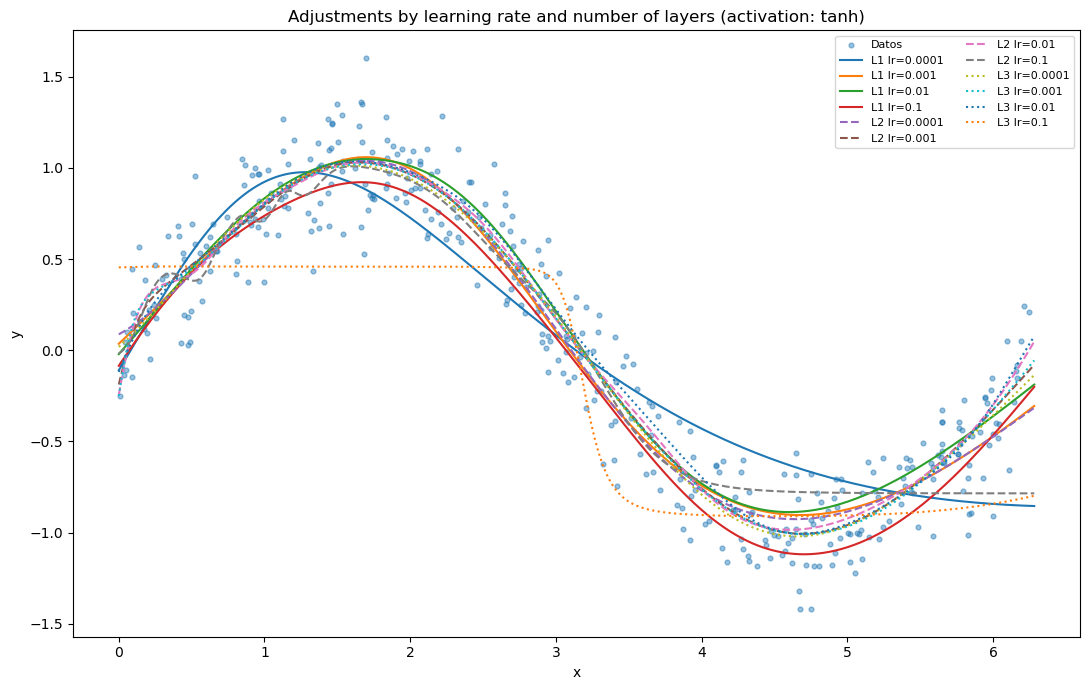

In [8]:
plt.figure(figsize=(11,7))
plt.scatter(x, y, s=12, alpha=0.45, label='Datos')

styles = {1:'-', 2:'--', 3:':'}
for L in layer_options:
    for lr in lrs:
        yg = fits[(L, lr)]['y_hat']
        lbl = f"L{L} lr={lr}"
        plt.plot(x_grid, yg, linestyle=styles[L], label=lbl)

plt.title(f"Adjustments by learning rate and number of layers (activation: {base_activation})")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\DML_NN\Python\Output\Adjustments_by_learning.png", dpi=300, bbox_inches='tight')
plt.show()


### Step 3: Short answer (0.5 pts)

To determine which learning rate works best for each network depth, we compared the MSE across all trained models. Here are the best results:

Layers = 1 → Best lr = 0.001 | MSE ≈ 0.1618
Layers = 2 → Best lr = 0.01 | MSE ≈ 0.0413
Layers = 3 → Best lr = 0.01 | MSE ≈ 0.0406

---

###  Interpretation (Clear and Expanded)

- The **learning rate (lr)** determines how large each update step is when optimizing the weights.
  - **Too high (0.1):** the model becomes unstable, oscillates, or diverges.
  - **Too low (0.0001):** the model learns very slowly and may underfit the data.

- **From the results and plot:**
  - With **1 hidden layer**, the best performance is achieved with a smaller learning rate (**0.001**), which gives smoother convergence.
  - With **2 or 3 hidden layers**, the model is more complex and benefits from a slightly higher learning rate (**0.01**) to properly learn the pattern without getting stuck.

---

###  Main Insight

> As we increase the number of hidden layers, the model becomes more expressive but also harder to optimize.  
> A slightly larger learning rate (like 0.01) helps deeper networks converge faster and reach lower error.  
> However, very large values still destabilize learning, while very small values cause slow convergence and underfitting.

---





## Question 2 - DML (12 points)


### 1) Processing Data and definition of variables (0.5 pts)

In [9]:
path = r"C:\Users\User\Desktop\DML_NN\Python\Input\penn_jae.dat.txt"
df0 = pd.read_csv(path, sep=r"\s+", header=None, engine="python")

df = df0.iloc[1:].copy()
df.columns = df0.iloc[0].astype(str).str.strip()
df = df.apply(pd.to_numeric, errors='ignore')
df.reset_index(drop=True, inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_27172\127695149.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [10]:
df = df[df['tg'].isin([0, 4])].reset_index(drop=True)
df['T4'] = (df['tg'] == 4).astype(int)
df = df[df['inuidur1'] > 0].copy()
df['y'] = np.log(df['inuidur1'])

dep_dummies = pd.get_dummies(df['dep'], prefix='dep', drop_first=False, dtype=int)
df = pd.concat([df, dep_dummies], axis=1)

X_features = [
    'female', 'black', 'othrace',
    'dep_1', 'dep_2',
    'q2', 'q3', 'q4', 'q5', 'q6',
    'recall', 'age1t35', 'age1t54',
    'durable', 'nondurable', 'lusd', 'husd'
]

X_features = [var for var in X_features if var in df.columns]

X = df[X_features]
d = df['T4']
y = df['y']

df.head()



,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,durable,nondurable,lusd,husd,muld,T4,y,dep_0,dep_1,dep_2
0,10824,0,18,18,0,0,0,0,2,0,...,0,0,0,1,0,0,2.890372,0,0,1
1,10824,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0.000000,1,0,0
2,10747,0,27,27,0,0,0,0,0,0,...,0,0,1,0,0,0,3.295837,1,0,0
3,10607,4,9,9,0,0,0,0,0,0,...,0,0,0,0,1,1,2.197225,1,0,0
4,10831,0,27,27,0,0,0,0,1,0,...,1,0,1,0,0,0,3.295837,0,1,0


## II. Debiased ML



In [26]:
def dml_plr(y, d, X, learner_y="ols", learner_d="ols", K=5, random_state=123):
    y = np.asarray(y).astype(float)
    d = np.asarray(d)
    X = np.asarray(X)

    is_binary_d = np.array_equal(np.unique(d), np.array([0,1], dtype=d.dtype))
    d = d.astype(float)

    def get_m_learner(name):
        if name == "ols":
            return Pipeline([("sc", StandardScaler(with_mean=False)), ("lr", LinearRegression())])
        if name == "lasso":
            return Pipeline([("sc", StandardScaler()), ("ls", LassoCV(cv=5, random_state=random_state))])
        if name == "rf":
            return RandomForestRegressor(n_estimators=600, max_features="sqrt", random_state=random_state, n_jobs=-1)
        if name == "nn":
            return Pipeline([("sc", StandardScaler()),
                             ("mlp", MLPRegressor(hidden_layer_sizes=(64,64), max_iter=2000, random_state=random_state))])
        raise ValueError("learner_y desconocido")

    def get_g_learner(name, is_binary):
        if is_binary:
            if name == "ols":   # para binaria, usa logística
                return Pipeline([("sc", StandardScaler()), ("log", LogisticRegression(max_iter=2000))])
            if name == "lasso":
                return Pipeline([("sc", StandardScaler()), ("log", LogisticRegression(penalty="l1", solver="saga", max_iter=4000))])
            if name == "rf":
                return RandomForestClassifier(n_estimators=600, max_features="sqrt", random_state=random_state, n_jobs=-1)
            if name == "nn":
                return Pipeline([("sc", StandardScaler()),
                                 ("mlp", MLPClassifier(hidden_layer_sizes=(64,64), max_iter=2000, random_state=random_state))])
        else:

            return get_m_learner(name)
        raise ValueError("learner_d desconocido")

    kf = KFold(n_splits=K, shuffle=True, random_state=random_state)

    y_tilde = np.zeros_like(y, dtype=float)
    d_tilde = np.zeros_like(d, dtype=float)

    for train, test in kf.split(X):
        Xm, Xg = X[train], X[train]
        ym, yg = y[train], d[train]


        m = get_m_learner(learner_y)
        m.fit(Xm, ym)
        mhat = m.predict(X[test])


        g = get_g_learner(learner_d, is_binary_d)
        g.fit(Xg, yg)
        ghat = g.predict_proba(X[test])[:,1] if (is_binary_d and hasattr(g, "predict_proba")) else g.predict(X[test])

        y_tilde[test] = y[test] - mhat
        d_tilde[test] = d[test] - ghat


    model = sm.OLS(y_tilde, d_tilde) 
    res = model.fit(cov_type="HC1")
    theta = float(res.params[0])
    se = float(res.bse[0])
    return theta, se, res


X_controls = sm.add_constant(pd.concat([pd.Series(d, name="T"), X], axis=1))
ols_ctrl = sm.OLS(y, X_controls).fit(cov_type="HC1")
theta_ols_ctrl = float(ols_ctrl.params["T"])
se_ols_ctrl = float(ols_ctrl.bse["T"])

setups = {
    "DML-OLS/Logit":   ("ols","ols"),
    "DML-Lasso/Logit": ("lasso","lasso"),
    "DML-RF":          ("rf","rf"),
    "DML-NN":          ("nn","nn")
}

rows = []
for name, (ly, ld) in setups.items():
    theta, se, _ = dml_plr(y, d, X, learner_y=ly, learner_d=ld, K=5, random_state=123)
    rows.append({"Método": name, "ATE (θ̂)": theta, "SE robusto": se})

rows.insert(0, {"Método": "OLS con controles", "ATE (θ̂)": theta_ols_ctrl, "SE robusto": se_ols_ctrl})
tabla = pd.DataFrame(rows)

tabla["z"] = np.abs(tabla["ATE (θ̂)"]/tabla["SE robusto"])



In [28]:
tabla_styled = (
    tabla.set_index("Método")
         .style.set_caption("Result DML with Cross-Fitting")
         .format("{:.4f}")
         .background_gradient(cmap="Blues")
         .set_table_styles([{"selector":"caption","props":[("font-size","16px"),("font-weight","bold")]}])
)
display(tabla_styled)

best = tabla.iloc[tabla["z"].idxmax()]
theta_final = float(best["ATE (θ̂)"])
se_final = float(best["SE robusto"])
modelo_final = best["Método"]

print(f"\nModel selected: {modelo_final}")
print(f"ATE (θ̂) = {theta_final:.4f}  |  SE = {se_final:.4f}  |  z = {abs(theta_final/se_final):.2f}")



,ATE (θ̂),SE robusto,z
Método,,,
OLS con controles,-0.0773,0.0354,2.1853
DML-OLS/Logit,-0.0735,0.0353,2.0818
DML-Lasso/Logit,-0.0736,0.0353,2.0834
DML-RF,-0.0813,0.0352,2.3101
DML-NN,-0.0837,0.0349,2.3978



Model selected: DML-NN
ATE (θ̂) = -0.0837  |  SE = 0.0349  |  z = 2.40


## III. No cross-fitting

In [19]:
def dml_no_cf(y, d, X, learner_y, learner_d, rs=123):
    if learner_y == "ols":
        m = Pipeline([("sc", StandardScaler(with_mean=False)), ("lr", LinearRegression())])
    elif learner_y == "lasso":
        m = Pipeline([("sc", StandardScaler()), ("ls", LassoCV(cv=5, random_state=rs))])
    elif learner_y == "rf":
        m = RandomForestRegressor(n_estimators=600, max_features="sqrt", random_state=rs, n_jobs=-1)
    elif learner_y == "nn":
        m = Pipeline([("sc", StandardScaler()), ("mlp", MLPRegressor(hidden_layer_sizes=(64,64), max_iter=2000, random_state=rs))])

    if learner_d == "ols":
        g = Pipeline([("sc", StandardScaler()), ("log", LogisticRegression(max_iter=2000))])
    elif learner_d == "lasso":
        g = Pipeline([("sc", StandardScaler()), ("log", LogisticRegression(penalty="l1", solver="saga", max_iter=4000))])
    elif learner_d == "rf":
        g = RandomForestClassifier(n_estimators=600, max_features="sqrt", random_state=rs, n_jobs=-1)
    elif learner_d == "nn":
        g = Pipeline([("sc", StandardScaler()), ("mlp", MLPClassifier(hidden_layer_sizes=(64,64), max_iter=2000, random_state=rs))])

    m.fit(X, y)
    g.fit(X, d)

    mhat = m.predict(X)
    ghat = g.predict_proba(X)[:,1] if hasattr(g, "predict_proba") else g.predict(X)

    y_tilde = np.asarray(y, float) - mhat
    d_tilde = np.asarray(d, float) - ghat

    res = sm.OLS(y_tilde, d_tilde).fit(cov_type="HC1")
    est = float(res.params[0])
    se = float(res.bse[0])
    rmse_y = float(np.sqrt(np.mean((y - mhat) ** 2)))
    rmse_d = float(np.sqrt(np.mean((d - ghat) ** 2)))
    return est, se, rmse_y, rmse_d

setups = {
    "OLS_nocf":   ("ols","ols"),
    "Lasso_nocf": ("lasso","lasso"),
    "RF_nocf":    ("rf","rf"),
    "NN_nocf":    ("nn","nn"),
}

rows = []
for name, (ly, ld) in setups.items():
    est, se, rmse_y, rmse_d = dml_no_cf(y, d, X, ly, ld, rs=123)
    rows.append({"model": name, "estimate": est, "stderr": se, "rmse y": rmse_y, "rmse D": rmse_d})

table_nocf = pd.DataFrame(rows).set_index("model")
display(
    table_nocf.style
        .set_caption("Result DML without Cross-Fitting")
        .format("{:.4f}")
        .background_gradient(cmap="Blues")
        .set_table_styles([{"selector":"caption","props":[("font-size","16px"),("font-weight","bold")]}])
)

table_nocf["z"] = (table_nocf["estimate"].abs() / table_nocf["stderr"])

best_index = table_nocf["z"].idxmax()      
best_nocf = table_nocf.loc[best_index]    
print(f"Model selected (without CF): {best_index}  |  θ̂={best_nocf['estimate']:.4f}  SE={best_nocf['stderr']:.4f}  z={best_nocf['z']:.2f}")



,estimate,stderr,rmse y,rmse D
model,,,,
OLS_nocf,-0.0774,0.0353,1.1971,0.4736
Lasso_nocf,-0.0773,0.0353,1.1973,0.4736
RF_nocf,-0.0783,0.0359,1.1341,0.4490
NN_nocf,-0.0754,0.0357,1.1441,0.4522


Model selected (without CF): OLS_nocf  |  θ̂=-0.0774  SE=0.0353  z=2.19


# Comparison: DML with Cross-Fitting vs. No Cross-Fitting

## 1. What can you say about the RMSE for predicting y and d?

- The RMSE values for both ŷ and d̂ are lower in the **No Cross-Fitting** case.
- This happens because the models are predicting on the **same data they were trained on**, which leads to **overfitting and artificially low error**.
- With **Cross-Fitting**, predictions are made on **data not used during training**, so the RMSE reflects a more realistic **out-of-sample error**.

## 2. Why does one method yield lower RMSE than the other?

- **No Cross-Fitting** uses the full sample to both train and predict → produces the best in-sample fit → **lower RMSE**, but overfitted.
- **Cross-Fitting** trains on one fold and predicts on another → predictions are out-of-sample → **higher RMSE**, but more reliable.
- Therefore, **lower RMSE does not mean better causal estimation**, only better in-sample prediction.

## 3. What problem would we face if we estimated without cross-fitting?

- Without cross-fitting, the same data is used to:
  - Estimate the nuisance functions m(X) = E[Y|X] and g(X) = E[D|X],
  - And compute residuals ỹ = y – m̂(X) and d̃ = d – ĝ(X), which are then used to estimate θ.
- This creates **overfitting and dependence between residuals and nuisance estimates**, violating the **Neyman orthogonality condition**.
- As a consequence, the estimated treatment effect θ becomes **biased and possibly inconsistent**, even if the RMSE is lower.
